# All-qubit survey of the phase dependence of the $X$ and $\sqrt{X}$ gates

Due to some higher-order effects (?), $\sqrt{X}$ gate exhibits nonnegligible phase (frame) dependence on some qubits of some backends. This notebook surveys some of the backends I have access to.

## List all the backends

In [1]:
from qiskit_private_tools import backends_table, my_backends

backends_table()

My backends:
+-------------------------------------------------------------------------------+
|Name           |Nq |QV  |Chip            |Pulse|Shots|Exps|Jobs|Providers      |
+---------------+---+----+----------------+-----+-----+----+----+---------------+
|ibmq_manhattan | 65|   0|Hummingbird 2.00|Yes  | 8192| 900|   6|icepp          |
+---------------+---+----+----------------+-----+-----+----+----+---------------+
|ibmq_brooklyn  | 65|   0|Hummingbird 2.00|No   | 8192| 900|1069|icepp          |
+---------------+---+----+----------------+-----+-----+----+----+---------------+
|ibmq_montreal  | 27|   0|Falcon 4.00     |Yes  | 8192| 900|  22|icepp          |
+---------------+---+----+----------------+-----+-----+----+----+---------------+
|ibmq_toronto   | 27|   0|Falcon 4.00     |Yes  | 8192| 900|   2|icepp          |
+---------------+---+----+----------------+-----+-----+----+----+---------------+
|ibmq_sydney    | 27|   0|Falcon 4.00     |Yes  | 8192| 900|   5|icepp          |
+--

## Do the imports and set up the circuit templates

In [2]:
import datetime
import numpy as np
import h5py
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, IBMQ, transpile
from qiskit.circuit import Parameter
from qiskit.tools.monitor import job_monitor

In [24]:
phi = Parameter('phi')
phi_values = np.linspace(-np.pi, np.pi, 32)

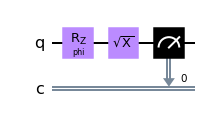

In [25]:
sx_circuit = QuantumCircuit(1, 1)
sx_circuit.rz(phi, 0)
sx_circuit.sx(0)
sx_circuit.measure(0, 0)

# One circuit per phi value
sx_circuits = [sx_circuit.assign_parameters({phi: phi_value}, inplace=False) for phi_value in phi_values]

sx_circuit.draw('mpl')

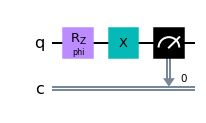

In [26]:
x_circuit = QuantumCircuit(1, 1)
x_circuit.rz(phi, 0)
x_circuit.x(0)
x_circuit.measure(0, 0)

# One circuit per phi value
x_circuits = [x_circuit.assign_parameters({phi: phi_value}, inplace=False) for phi_value in phi_values]

x_circuit.draw('mpl')

## Submit the experiments

Run the above circuits with the logical qubit 0 assigned to each physical qubit of the device. For each backend, there will be (Number of qubits) x (Number of phi points) experiments.

In [4]:
submit_jobs = False
experiment_date = datetime.date(2021, 9, 17)

if submit_jobs:
    for backend in my_backends.values():
        status = backend.status()
        config = backend.configuration()

        # Skip super-busy backends & backends that aren't very useful
        if status.pending_jobs >= 100 or config.max_experiments < 100:
            continue

        print('Submitting jobs to {}'.format(backend.name()))

        for exp_name, circuit_templates in [('SX', sx_circuits), ('X', x_circuits)]:
            print(' Experiment: {}'.format(exp_name))

            # Bundle the experiments as much as possible (one job contains experiments for multiple qubits)
            circuits = []
            job_name = '{}_{}_0_'.format(backend.name(), exp_name)

            for iq in range(config.n_qubits):
                for iphi, circuit in enumerate(circuit_templates):
                    circuit.name = '{}_{}_{}_{}/{}pi'.format(backend.name(), exp_name, iq, (iphi - phi_values.shape[0] // 2), phi_values.shape[0])

                print('  Transpiling for qubit {}'.format(iq))
                circuits += transpile(circuit_templates, backend=backend, initial_layout=[iq])

                if len(circuits) + len(circuit_templates) > config.max_experiments:
                    # List of circuits full - submit the job
                    job_name += str(iq)
                    print('  Submitting {} circuits as {}'.format(len(circuits), job_name))
                    if not (backend.name() == 'ibmq_manhattan' and iq == 27):
                        backend.run(circuits, shots=2048, job_name=job_name)

                    circuits = []
                    job_name = '{}_{}_{}_'.format(backend.name(), exp_name, iq + 1)

            if len(circuits) != 0:
                job_name += str(iq)
                print('  Submitting {} circuits as {}'.format(len(circuits), job_name))
                backend.run(circuits, shots=2048, job_name=job_name)

    # Wait for job completion
    for backend in my_backends.values():
        for job in backend.jobs():
            if job.creation_date().date() == datetime.date(2021, 9, 17):
                job_monitor(job)

## Save the results to an HDF5 file

In [8]:
with h5py.File('phi_dependence_survey.h5', 'w') as out:
    for backend in my_backends.values():
        try:
            group = out[backend.name()]
        except KeyError:
            group = out.create_group(backend.name())
            
        for job in backend.jobs():
            if not (job.creation_date().date() == experiment_date and job.status().name == 'DONE'):
                continue
                
            exp_name, qstart, qend = job.name().replace('{}_'.format(backend.name()), '').split('_')
            result = job.result()
            counts = result.get_counts()

            try:
                exp_group = group[exp_name]
            except KeyError:
                exp_group = group.create_group(exp_name)
                
            for iq in range(int(qstart), int(qend) + 1):
                try:
                    dataset = exp_group['Q{}'.format(iq)]
                except:
                    dataset = exp_group.create_dataset('Q{}'.format(iq), (phi_values.shape[0], 2), 'i')
                    
                idata = iq - int(qstart)
                data = counts[idata * phi_values.shape[0]:(idata + 1) * phi_values.shape[0]]
                
                for icount, count in enumerate(data):
                    dataset[icount, 0] = count['0']
                    dataset[icount, 1] = count['1']

## Plot the $\phi$ dependence

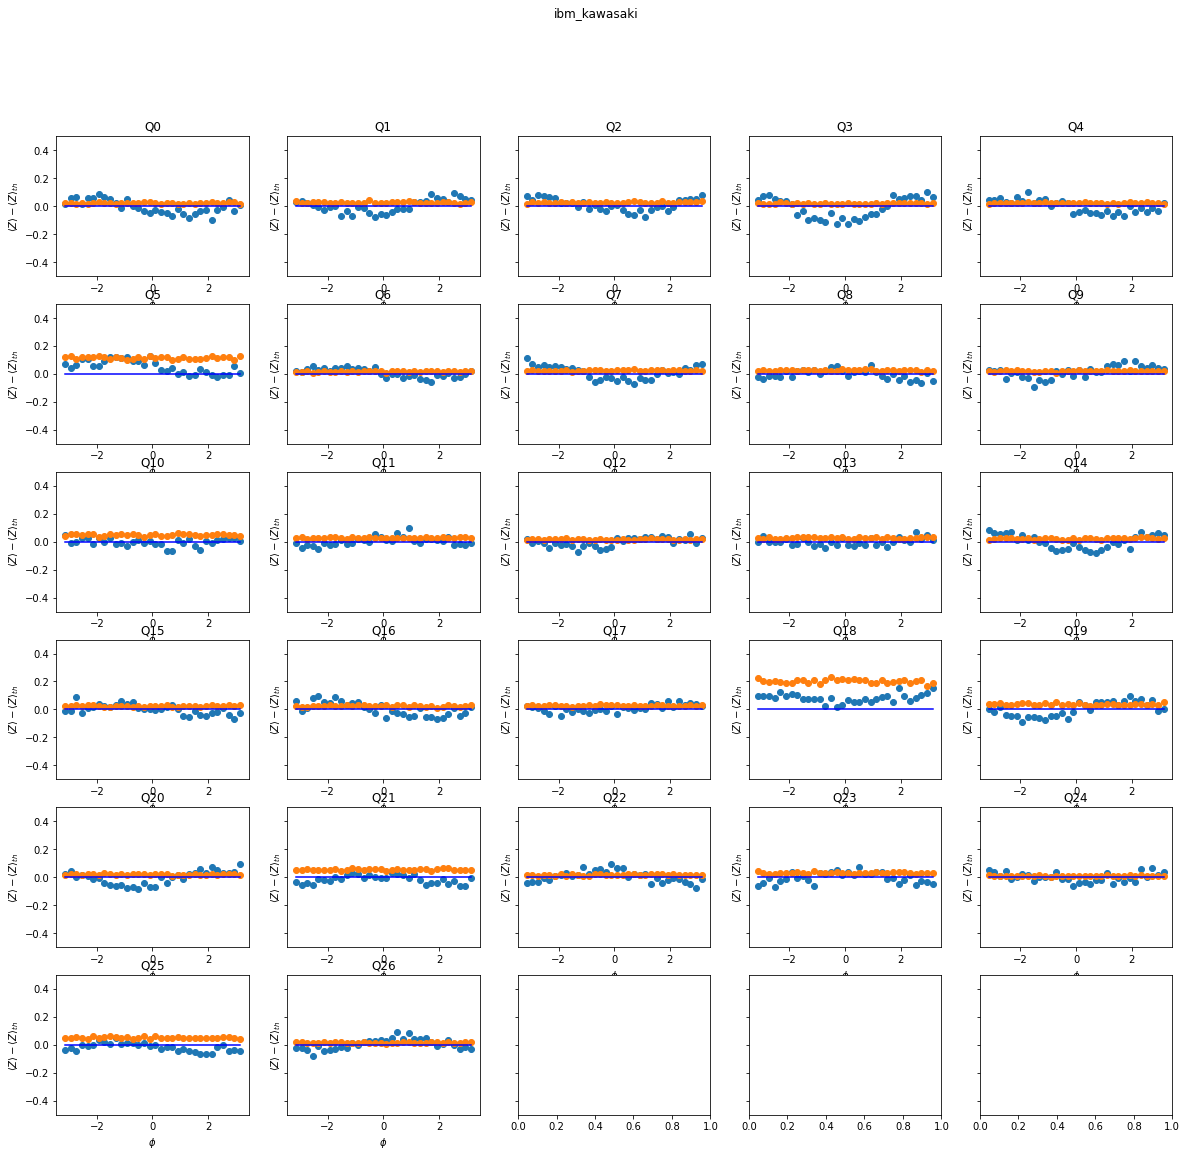

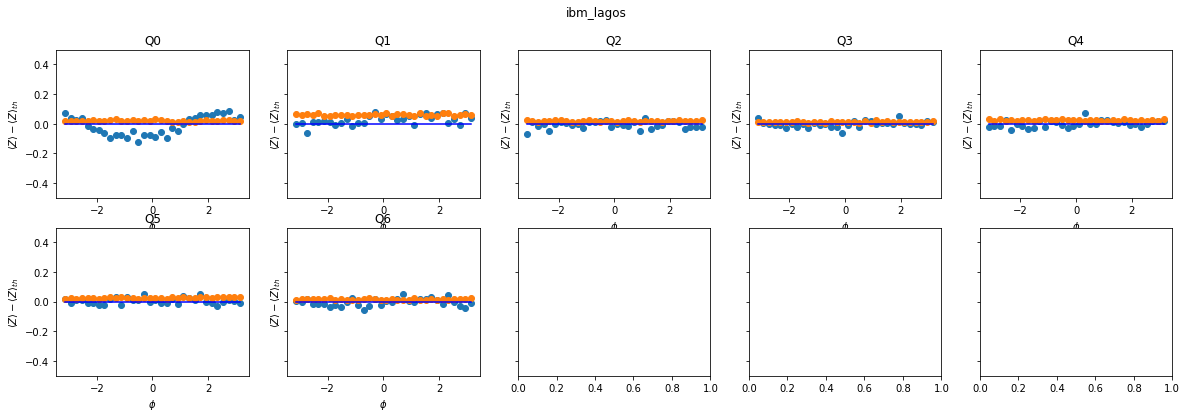

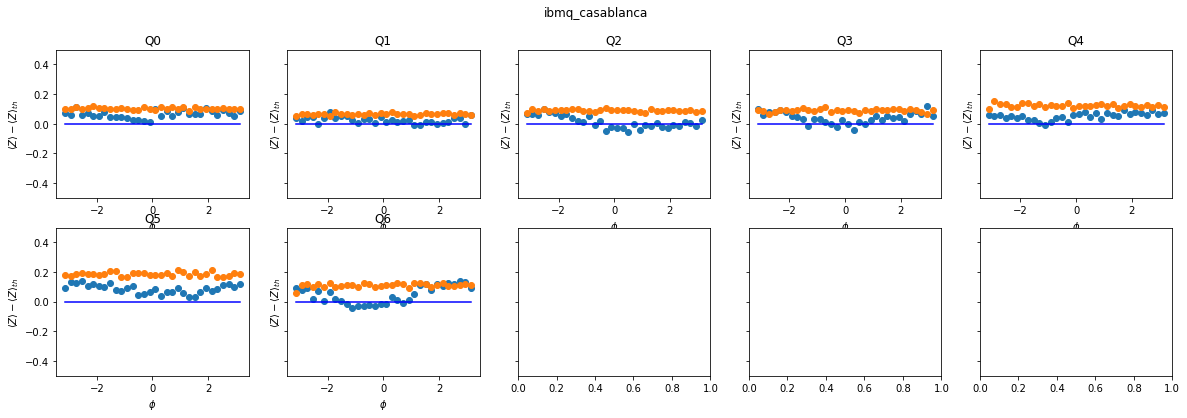

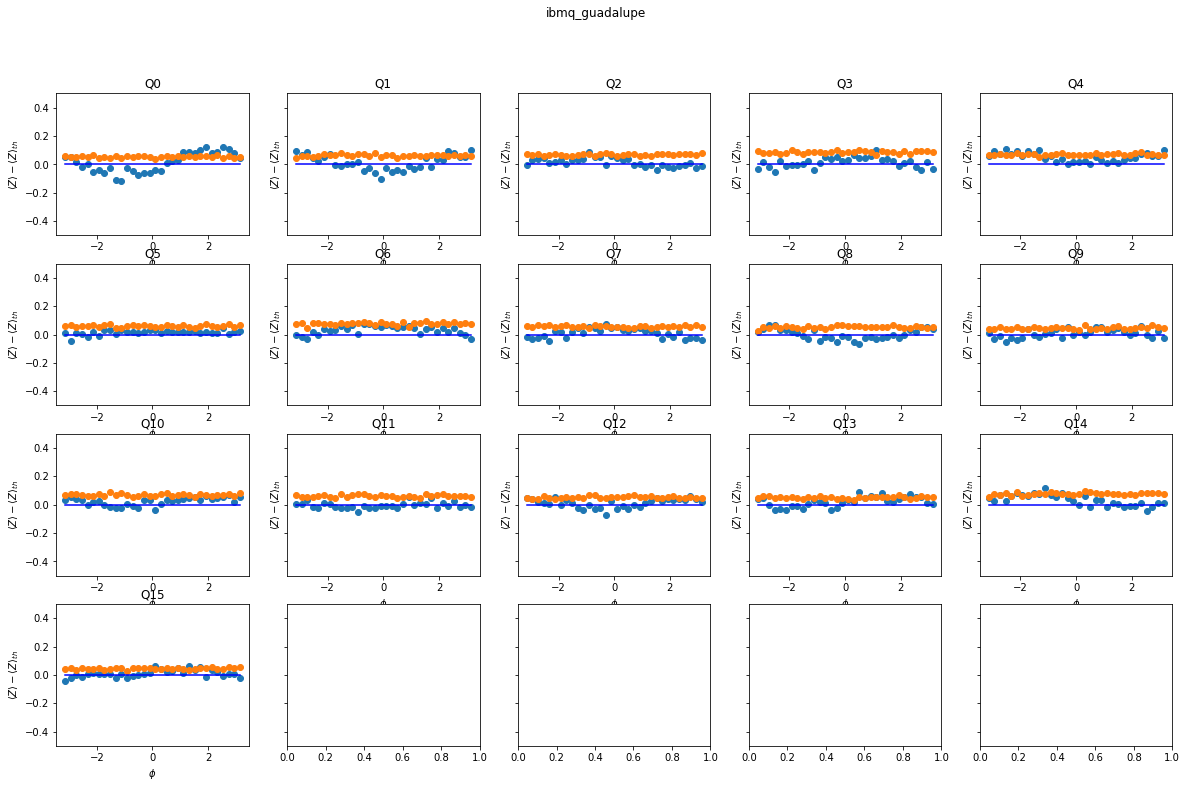

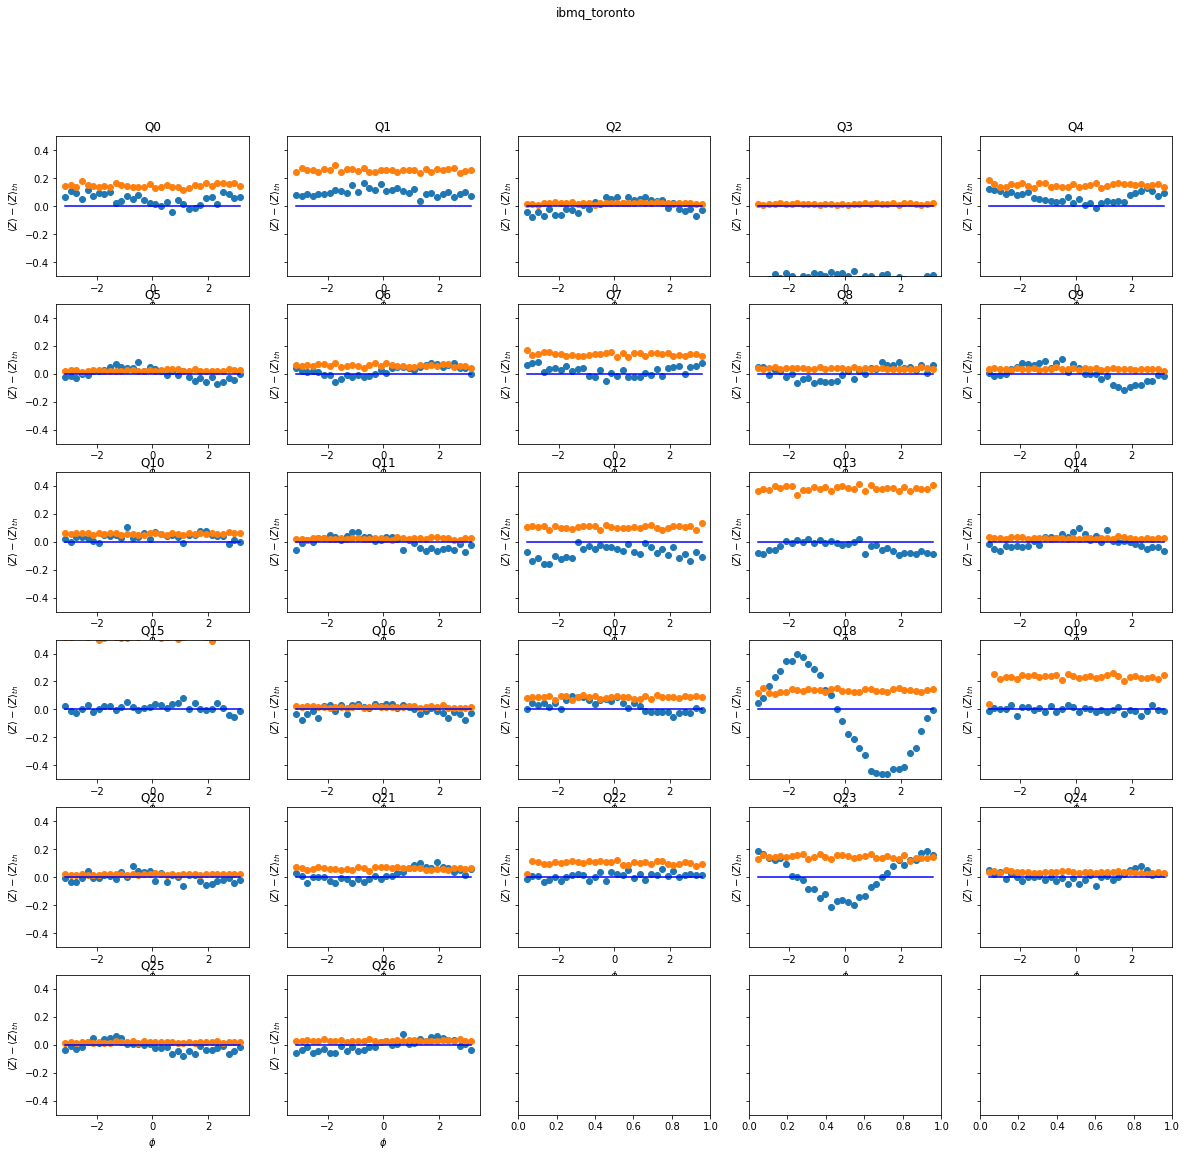

In [23]:
with h5py.File('phi_dependence_survey.h5', 'r') as source:
    for backend_name in source.keys():
        group = source[backend_name]
        if len(group.keys()) != 2:
            continue
            
        nq = my_backends[backend_name].configuration().n_qubits
        
        nrows = (nq - 1) // 5 + 1
        
        fig, axs = plt.subplots(nrows, 5, sharey=True, figsize=(20, 3 * nrows), squeeze=False)
        fig.suptitle(backend_name)
        
        for iq in range(nq):
            ax = axs[iq // 5, iq % 5]
            ax.set_xlabel(r'$\phi$')
            ax.set_ylabel(r'$\langle Z \rangle - \langle Z \rangle_{th}$')
            ax.set_title('Q{}'.format(iq))
            
            ax.plot([-np.pi, np.pi], [0., 0.], 'b-')
            
            data = group['SX']['Q{}'.format(iq)][:]
            ax.scatter(phi_values, (data[:, 0] - data[:, 1]) / np.sum(data, axis=1))
            data = group['X']['Q{}'.format(iq)][:]
            ax.scatter(phi_values, (data[:, 0] - data[:, 1]) / np.sum(data, axis=1) + 1.)
            
            ax.set_ylim(-0.5, 0.5)